In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression,\
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from nnpiv.rkhs import ApproxRKHSIVCV, RKHSIVCV, RKHS2IVL2
from nnpiv.neuralnet import AGMM2
from sklearn.pipeline import Pipeline

from pathlib import Path
import numpy as np
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
from nnpiv.tsls import tsls, regtsls
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.cluster import KMeans
from nnpiv.neuralnet.rbflayer import gaussian, inverse_multiquadric
p = 0.1  # dropout prob of dropout layers throughout notebook
n_hidden = 100  # width of hidden layers throughout notebook


device = torch.cuda.current_device() if torch.cuda.is_available() else None

In [2]:
from nnpiv.semiparametrics import DML_longterm, DML_joint_longterm
from nnpiv.semiparametrics import DML_npiv

In [3]:

# Read the CSV file into a DataFrame
df = pd.read_csv('../data/data_star.csv', header=0)


In [4]:
df = pd.read_csv('../data/data_star.csv', header=0)

# Bind covariates
Xnan = df[["z_score_prior"]].values
X = df[["z_score_prior"]].values
G = df[["G"]].values
D = df[["D"]].values
S = df[["z_score3"]].values
V = df[["z_score_prior"]].values
Y = df[["z_score8"]].values


#drop NaNs
X = X[~np.isnan(Xnan)].reshape(-1,1)
G = G[~np.isnan(Xnan)].reshape(-1,1)
D = D[~np.isnan(Xnan)].reshape(-1,1)
S = S[~np.isnan(Xnan)].reshape(-1,1)
Y = Y[~np.isnan(Xnan)].reshape(-1,1)
V = V[~np.isnan(Xnan)].reshape(-1,1)

ones = np.ones((X.shape[0], 1))
 

In [5]:
df = pd.read_csv('../data/data_star.csv', header=0)
# Bind covariates
Xnan = df[["z_score_prior"]].values
X = df[["z_score_prior"]].values
G = df[["G"]].values
D = df[["D"]].values
S = df[["z_score3"]].values
V = df[["z_score_prior"]].values
Y = df[["z_score8"]].values


#drop NaNs
X = X[~np.isnan(Xnan)].reshape(-1,1)
G = G[~np.isnan(Xnan)].reshape(-1,1)
D = D[~np.isnan(Xnan)].reshape(-1,1)
S = S[~np.isnan(Xnan)].reshape(-1,1)
Y = Y[~np.isnan(Xnan)].reshape(-1,1)
V = V[~np.isnan(Xnan)].reshape(-1,1)

ones = np.ones((X.shape[0], 1))

In [6]:
percentiles = np.arange(5, 95, 5)
#Input the vector little v where wwe want to center local estimate theta
v_values = np.percentile(V, percentiles)


In [7]:

            
def _get_learner(n_t):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

fitargs = {'n_epochs': 600, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 
                      'learner_l2': 1e-3, 'adversary_l2': 1e-4, 'device' : device }

agmm2_model_1 = AGMM2(learnerh = _get_learner(1), learnerg = _get_learner(2),
                     adversary1 = _get_adversary(2), adversary2 = _get_adversary(1))



: 

In [8]:
    
dml_2sls = DML_joint_longterm(Y, D, S, G, X1=None, V=X, v_values = v_values,
                        estimator='MR',
                        loc_kernel='gau',
                        bw_loc='silverman',
                        longterm_model='surrogacy',
                        model1 = agmm2_model_1,
                        nn_1 = True,
                        fitargs1=None,
                n_folds=10, n_rep=1, CHIM = False, prop_score=LogisticRegression(max_iter=2000), opts = {'lin_degree': 1})

theta, vart, ci = dml_2sls.dml()

lower_ci = ci[:, 0]
upper_ci = ci[:, 1]
yerr = [theta - lower_ci, upper_ci - theta]

plt.figure(figsize=(7, 3))
plt.plot(theta)
plt.axhline(np.mean(theta, axis=0), linewidth=1)  # Adjust line properties as needed
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Adjust line properties as needed

Rep: 1


 10%|█         | 1/10 [18:15<2:44:15, 1095.06s/it]

Rep: 1


100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


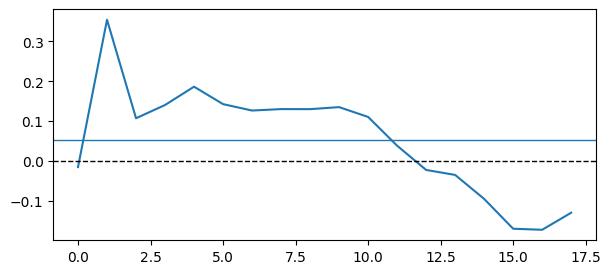

In [ ]:

dml_2sls = DML_joint_longterm(Y, D, S, G, X1=None, V=X, v_values = v_values,
                        estimator='MR',
                        loc_kernel='gau',
                        bw_loc='silverman',
                        ci_type = 'pointwise',
                        longterm_model='latent_unconfounded',
                        model1 = agmm2_model_1,
                        nn_1 = True,
                n_folds=10, n_rep=1, CHIM = False, prop_score=LogisticRegression(max_iter=2000), opts = {'lin_degree': 1})

theta_l, vart_l, ci_l = dml_2sls.dml()

lower_ci_l = ci_l[:, 0]
upper_ci_l = ci_l[:, 1]
yerr_l = [theta_l - lower_ci_l, upper_ci_l - theta_l]

plt.figure(figsize=(7, 3))
plt.plot(theta_l)
plt.axhline(np.mean(theta_l, axis=0), linewidth=1)  # Adjust line properties as needed
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Adjust line properties as needed

Rep: 1


100%|██████████| 10/10 [00:00<00:00, 19.28it/s]


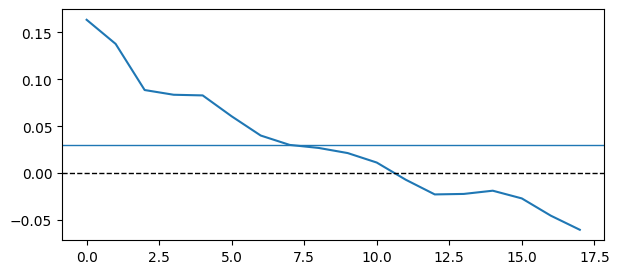

In [ ]:

ind = np.where(G == 0)[0]
Y1 = Y[ind]
D1 = D[ind]
X11 = X[ind]
ones1 = ones[ind]

dml_npiv = DML_npiv(Y1, D1, ones1, ones1, V=X11, v_values = v_values,
                        estimator='OR',
                        loc_kernel='gau',
                        bw_loc='silverman',
                        ci_type = 'pointwise',
                        model1 = tsls(),
                        modelq1 = tsls(),
                n_folds=10, n_rep=1, CHIM = False, prop_score=LogisticRegression(max_iter=2000), opts = {'lin_degree': 1})

theta_oracle, vart_oracle, ci_oracle = dml_npiv.dml()

lower_ci_oracle = ci_oracle[:, 0]
upper_ci_oracle = ci_oracle[:, 1]
yerr_oracle = [theta_oracle - lower_ci_oracle, upper_ci_oracle - theta_oracle]

plt.figure(figsize=(7, 3))
plt.plot(theta_oracle)
plt.axhline(np.mean(theta_oracle, axis=0), linewidth=1)  # Adjust line properties as needed
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Adjust line properties as needed

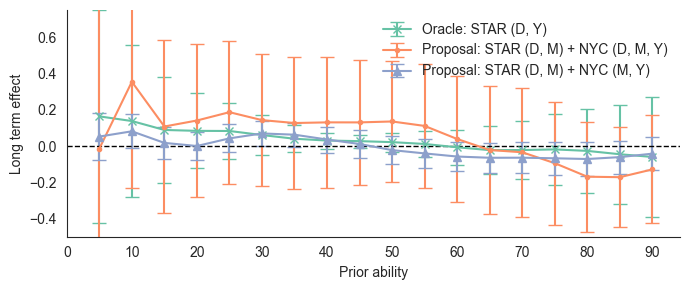

In [ ]:

plt.figure(figsize=(7, 3))
sns.set_style("white")
sns.set_palette("Set2")

# Generating the line plot with error bars (confidence intervals)
plt.errorbar(percentiles, theta_oracle, yerr=yerr_oracle, marker='x', capsize=5, label='Oracle: STAR (D, Y)')
plt.errorbar(percentiles, theta_l, yerr=yerr_l, marker='.', capsize=5, label='Proposal: STAR (D, M) + NYC (D, M, Y)')
plt.errorbar(percentiles, theta, yerr=yerr, marker='^', capsize=5, label='Proposal: STAR (D, M) + NYC (M, Y)')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Adjust line properties as needed

#set size of y-axis
plt.ylim(-0.5, 0.75)
#set x-axis limits


plt.xlabel('Prior ability')
plt.ylabel('Long term effect')
plt.legend(frameon=False)

plt.tight_layout()
sns.despine()

# Setting x-axis ticks every 10 units
plt.xticks(np.arange(0, 100, 10))
plt.savefig('plot_longterm_cate.png', dpi=600, bbox_inches='tight')  # Adjust options as needed
